# Program

In [1]:
import os
import time
import sys
import json
import copy
import math
import numpy as np
import ipyvolume as ipv
import pathlib
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt

import tyssue
import tyssue.dynamics
import tyssue.dynamics.factory
import tyssue.stores
import tyssue.config.geometry
import tyssue.io
import tyssue.draw
import tyssue.draw.plt_draw
from tyssue import SheetGeometry as geom
from tyssue.dynamics import effectors, units
from tyssue.dynamics.factory import model_factory
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.utils import to_nd

import scipy
import scipy.optimize
from scipy.spatial.distance import squareform, pdist, cdist

Verbose = False

%matplotlib inline

SIM_DIR = pathlib.Path('.')

#from polarity.solver import find_energy_min

In [2]:
from tyssue import config, Sheet, PlanarGeometry
from tyssue.dynamics import effectors, model_factory
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.utils import data_at_opposite
from tyssue.solvers import QSSolver


## Init 

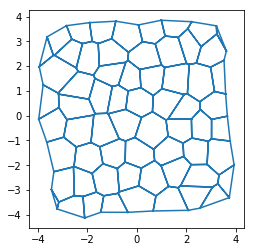

In [3]:
sheet = Sheet.planar_sheet_2d('jam', 10, 10, 1, 1, noise=0.2)
PlanarGeometry.update_all(sheet)
solver = QSSolver(with_t1=False, with_collisions=False)


sheet.remove(sheet.cut_out([[0, 10], [0, 10]]))
sheet.sanitize(trim_borders=True)
PlanarGeometry.scale(sheet, sheet.face_df.area.mean()**-0.5, ['x', 'y'])
PlanarGeometry.center(sheet)
PlanarGeometry.update_all(sheet)
sheet.reset_index()
sheet.reset_topo()

fig, ax = sheet_view(sheet, mode='quick')

In [4]:
# Mettre des valeurs de base pour la myosine et bazooka sur chaque bord de la cellule
sheet.face_df['myosin_max'] = 100
sheet.face_df['bazooka_max'] = 100

#sheet.edge_df['myosin'] = np.random.uniform(0, 10, sheet.Ne)
#sheet.edge_df['bazooka'] = np.random.uniform(0, 10, sheet.Ne)
sheet.edge_df['myosin'] = 10
sheet.edge_df['bazooka'] = 10
sheet.edge_df['line_tension'] = 0.2

sheet_init = sheet.copy(deep_copy=True)

#### Keep a copy of the initial sheet
 so that we can try several times the bloc below with no need to run each time the whole thing from the start
 
 The copy is also used to make compared graphics in the end

In [5]:
InitialSheet = copy.deepcopy(sheet)

In [6]:
"""class LineTensionPolarity(effectors.AbstractEffector):
    #Passive force : µ*l
    #Active force : myosin*myosin_force_constant(=2nN)

    dimensions = units.line_tension
    magnitude = "line_tension"
    label = "line_tension"
    element = "edge"
    specs = {"edge": 
             {"is_active",
              "line_tension",
              "myosin",
              "length"}}

    spatial_ref = "mean_length", units.length

    @staticmethod
    def energy(eptm):
        return eptm.edge_df.eval(tive " 
            # Values from lan et al 2018.
        )  # accounts for half edges
        
    @staticmethod
    def gradient(eptm):
        grad_srce = -eptm.edge_df[eptm.ucoords] * to_nd(
            eptm.edge_df.eval("0.14*is_active "),
            len(eptm.coords)
        )
        grad_srce.columns = ["g" + u for u in eptm.coords]
        grad_trgt = -grad_srce
        return grad_srce, grad_trgt
    """
    
    
class ChemGeom(PlanarGeometry):
    
    @classmethod
    def update_all(cls, sheet):
        super().update_all(sheet)
        #cls.update_concentrations(sheet)
        cls.update_tension(sheet)
        
    @staticmethod
    def update_tension(sheet):
        sheet.edge_df['line_tension'] = sheet.edge_df.eval(
            '0.00324 * myosin') + sheet.settings["tension0"]

    @staticmethod
    def update_concentrations(sheet):
        sheet.edge_df['concentration'] = sheet.edge_df.eval("protein_number / length")
        sheet.face_df['concentration'] = (
            sheet.face_df['total_protein']
            - sheet.sum_face(sheet.edge_df["protein_number"]).values.ravel()
        ) / sheet.face_df["area"]
        sheet.edge_df['o_protein_number'] = data_at_opposite(
            sheet, sheet.edge_df["protein_number"], free_value=0)
        sheet.edge_df['b_concentration'] = sheet.upcast_face('concentration')
        
class Compression(effectors.AbstractEffector):
    
    @staticmethod
    def energy(sheet):
        return sheet.vert_df.eval('0.2 * compression * x**2')
        
    @staticmethod
    def gradient(sheet):
        grad = sheet.vert_df[sheet.coords].copy()
        grad.columns = ['gx', 'gy']
        grad['gy'] = 0
        grad['gx'] = sheet.vert_df.eval("compression * x")
        return grad, None
        

Reseting column line_tension of the edge dataset with new specs
Reseting column is_alive of the face dataset with new specs
Reseting column is_active of the vert dataset with new specs


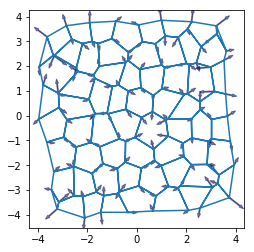

In [7]:
model = model_factory(
                    [
                    effectors.LineTension,
                    #effectors.FaceContractility,
                    effectors.FaceAreaElasticity,
                    ], effectors.FaceAreaElasticity)

polarity_specs = {
    "edge": {
        #auto-recrutement
        'qmyosin' : 0.35,
        'qbazooka' : 0.67,
        #desorption
        'amyosin' : 0.15,
        'abazooka' : 0.35,
        #recrutement aleatoire?
        'bmyosin' : 0.1,
        'bbazooka': 0.1,
        #inhibition
        'k' : 0.6,
        #enrichissement edge oppose
        'qob' : 0.8,
        #retroaction de la tension
        'Tm' : 0.4,
        'myosin_tension' : 2,
    },
}

dynamics_specs = {
    "edge": {
        "is_active": 1,
        "line_tension": 0.02,
        "ux": 0.0,
        "uy": 0.0,
        "uz": 0.0,
    },
    "face": {
        "is_alive": 1,
        "area_elasticity": 1.,
        "prefered_area": 1.,
        "contractility": 0.12
    },
    "vert": {
        "compression": 1.e-3,
        "extension": 1.,
        "is_active": 1,
        "viscosity": 1e-2,
    },
    "settings": {
        "tension0": 0.01
    }
}


sheet.update_specs(polarity_specs)
sheet.update_specs(dynamics_specs, reset=True)
sheet.get_opposite()

fig, ax = plot_forces(sheet, ChemGeom, model, list('xy'), scaling=1)
InitialSheet = copy.deepcopy(sheet)

In [8]:
sheet = copy.deepcopy(InitialSheet)



In [9]:
def update_protein_quantity(sheet, dt=0.1):
    #auto-recrutement
    qmyosin = polarity_specs['edge']['qmyosin']
    qbazooka = polarity_specs['edge']['qbazooka']
    #desorption
    amyosin = polarity_specs['edge']['amyosin']
    abazooka = polarity_specs['edge']['abazooka']
    #recrutement aleatoire?
    bmyosin = polarity_specs['edge']['bmyosin']
    bbazooka = polarity_specs['edge']['bbazooka']
    #inhibition
    k = polarity_specs['edge']['k']
    #enrichissement edge oppose
    qob = polarity_specs['edge']['qob']
    #Retroaction de la tension
    Tm = polarity_specs['edge']['Tm']
    
    for e in sheet.edge_df.itertuples() : 
        
        ## Myosin
        # Myosin restante dans le cytoplasme
        m_cyto = (sheet.face_df.loc[e.face].myosin_max
                  - sheet.edge_df.loc[sheet.edge_df.face == e.face].myosin.sum())

        dm = (qmyosin*e.myosin*m_cyto
             - amyosin*e.myosin 
             - k*e.bazooka
             + bmyosin * m_cyto
             + Tm * e.line_tension)*dt
       
        # si dm est plus petit que la quantite de myosine presente sur la jonction
        #      => soustrait la quantite de myosine de la jonction
        if dm < -e.myosin:
            sheet.edge_df.loc[e.Index, 'myosin'] += -e.myosin
        # si dm est plus grand que la quantite de myosine presente dans le cytoplasme
        elif dm > m_cyto:
            # s'il y a de la myosine dans le cytoplasme 
            #    => ajout de la myosine du cytoplasme a la jonction
            if m_cyto > 0:
                sheet.edge_df.loc[e.Index, 'myosin'] += m_cyto
        # Ajout directement de dm
        else: 
            sheet.edge_df.loc[e.Index, 'myosin'] += dm
        
        
        ## Bazooka
        # Bazooka restant dans le cytoplasme
        b_cyto = (sheet.face_df.loc[e.face].bazooka_max
                  - sheet.edge_df.loc[sheet.edge_df.face == e.face].bazooka.sum())
        
        db = (qbazooka*e.bazooka*b_cyto
            - abazooka*e.bazooka
            + bbazooka*b_cyto)
        
        if e.opposite != -1:
            db += qob*sheet.edge_df.loc[e.opposite].bazooka
        db *= dt
            
        if db < -e.bazooka :
            sheet.edge_df.loc[e.Index, 'bazooka'] += -e.bazooka
        elif db > b_cyto:
            if b_cyto > 0:
                sheet.edge_df.loc[e.Index, 'bazooka'] += b_cyto
        else: 
            sheet.edge_df.loc[e.Index, 'bazooka'] += db
    
    

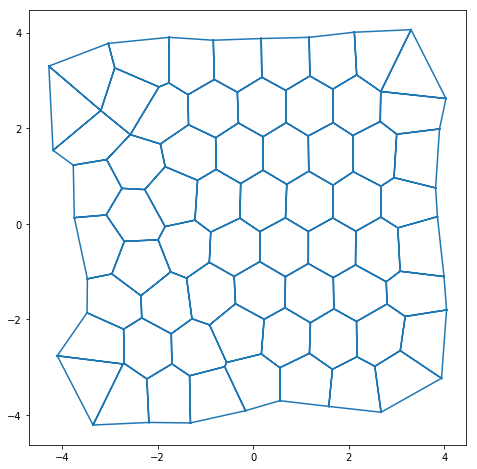

In [10]:
#sheet = copy.deepcopy(InitialSheet)
# Resolution mecanique

res = solver.find_energy_min(sheet, ChemGeom, model)

ChemGeom.update_all(sheet)

fig, ax = sheet_view(sheet, mode='quick',)
fig.set_size_inches((8, 8))

In [11]:
times = np.arange(0, 10, 0.1)
#times

In [12]:
from tyssue import History

history = History(sheet, extra_cols={'edge':['myosin', 'bazooka']})
for t in times :
    update_protein_quantity(sheet, 0.01)
    history.record(to_record = ['edge'])
    


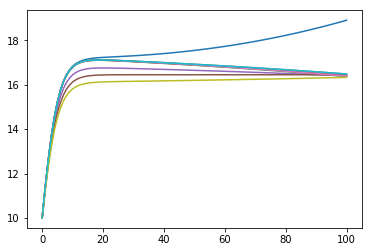

In [13]:
fig, ax = plt.subplots()
for e in range(10):
    edge_h0 = history.datasets['edge'][history.datasets['edge']['edge'] == e]
    ax.plot(edge_h0['time_id'], edge_h0['myosin'])



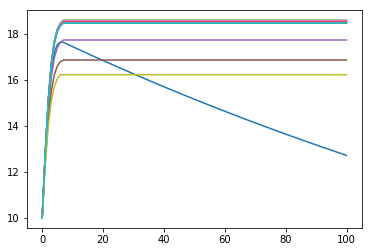

In [14]:
fig, ax = plt.subplots()
for e in range(10):
    edge_h0 = history.datasets['edge'][history.datasets['edge']['edge'] == e]
    ax.plot(edge_h0['time_id'], edge_h0['bazooka'])



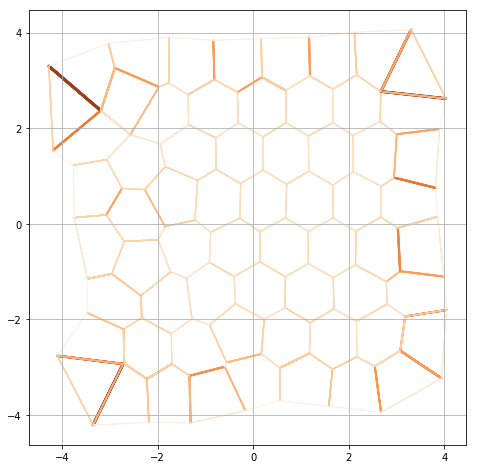

In [15]:
fig, ax = sheet_view(
    sheet, mode='2D',
    edge={
        "color": sheet.edge_df['bazooka'],
        "colormap":"Oranges",
        'head_width':0,
        'width': (0.1 + 3*sheet.edge_df['bazooka']/sheet.edge_df['bazooka'].max())},
    vert={"visible": False})
fig.set_size_inches((8, 8))

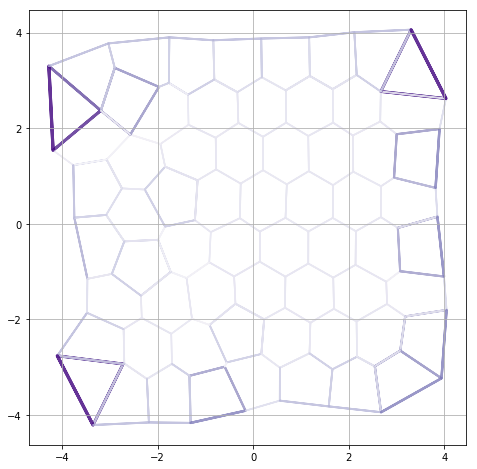

In [16]:
fig, ax = sheet_view(
    sheet, mode='2D',
    edge={
        "color": sheet.edge_df['myosin'],
        "colormap":"Purples",
        'head_width':0,
        'width': (0.1 + 3*sheet.edge_df['myosin']/sheet.edge_df['myosin'].max())},
    vert={"visible": False})
fig.set_size_inches((8, 8))

/home/admin-suz/anaconda3/lib/python3.6/site-packages/tyssue-0.3.3-py3.6-linux-x86_64.egg/tyssue/draw/plt_draw.py:224: UserWarning: Attempting to draw a colormap with a uniform value
  warnings.warn("Attempting to draw a colormap " "with a uniform value")


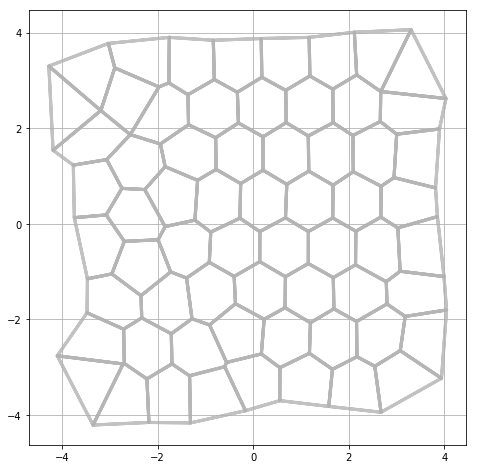

In [17]:
fig, ax = sheet_view(
    sheet, mode='2D',
    edge={
        "color": sheet.edge_df['line_tension'],
        "colormap":"Greens",
        'head_width':0,
        'width': (0.1 + 3*sheet.edge_df['line_tension']/sheet.edge_df['line_tension'].max())},
    vert={"visible": False})
fig.set_size_inches((8, 8))

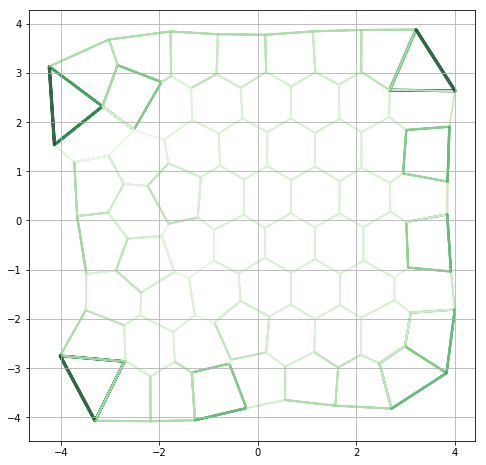

In [18]:
#sheet = copy.deepcopy(InitialSheet)
# Resolution mecanique
res = solver.find_energy_min(sheet, ChemGeom, model)
ChemGeom.update_all(sheet)
fig, ax = sheet_view(
    sheet, mode='2D',
    edge={
        "color": sheet.edge_df['line_tension'],
        "colormap":"Greens",
        'head_width':0,
        'width': (0.1 + 3*sheet.edge_df['line_tension']/sheet.edge_df['line_tension'].max())},
    vert={"visible": False})
fig.set_size_inches((8, 8))